#Stacked Regressions to predict House Prices 


##Serigne

**July 2017**

**If you use parts of this notebook in your scripts/notebooks, giving  some kind of credit would be very much appreciated :)  You can for instance link back to this notebook. Thanks!**

This competition is very important to me as  it helped me to begin my journey on Kaggle few months ago. I've read  some great notebooks here. To name a few:

1. [Comprehensive data exploration with Python][1] by **Pedro Marcelino**  : Great and very motivational data analysis

2. [A study on Regression applied to the Ames dataset][2] by **Julien Cohen-Solal**  : Thorough features engeneering and deep dive into linear regression analysis  but really easy to follow for beginners.

3. [Regularized Linear Models][3] by **Alexandru Papiu**  : Great Starter kernel on modelling and Cross-validation

I can't recommend enough every beginner to go carefully through these kernels (and of course through many others great kernels) and get their first insights in data science and kaggle competitions.

After that (and some basic pratices) you should be more confident to go through [this great script][7] by **Human Analog**  who did an impressive work on features engeneering. 

As the dataset is particularly handy, I  decided few days ago to get back in this competition and apply things I learnt so far, especially stacking models. For that purpose, we build two stacking classes  ( the simplest approach and a less simple one). 

As these classes are written for general purpose, you can easily adapt them and/or extend them for your regression problems. 
The overall approach is  hopefully concise and easy to follow.. 

The features engeneering is rather parsimonious (at least compared to some others great scripts) . It is pretty much :

- **Imputing missing values**  by proceeding sequentially through the data

- **Transforming** some numerical variables that seem really categorical

- **Label Encoding** some categorical variables that may contain information in their ordering set

-  [**Box Cox Transformation**][4] of skewed features (instead of log-transformation) : This gave me a **slightly better result** both on leaderboard and cross-validation.

- ** Getting dummy variables** for categorical features. 

Then we choose many base models (mostly sklearn based models + sklearn API of  DMLC's [XGBoost][5] and Microsoft's [LightGBM][6]), cross-validate them on the data before stacking/ensembling them. The key here is to make the (linear) models robust to outliers. This improved the result both on LB and cross-validation. 

  [1]: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
  [2]:https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
  [3]: https://www.kaggle.com/apapiu/regularized-linear-models
  [4]: http://onlinestatbook.com/2/transformations/box-cox.html
  [5]: https://github.com/dmlc/xgboost
 [6]: https://github.com/Microsoft/LightGBM
 [7]: https://www.kaggle.com/humananalog/xgboost-lasso

To my surprise, this does well on LB ( 0.11420 and top 4% the last time I tested it : **July 2, 2017** )



**Hope that at the end of this notebook, stacking will be clear for those, like myself, who found the concept not so easy to grasp**

## Imports

In [2]:
%pip install numpy==1.25.2 pandas==1.5.3 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 sklearn-pandas==2.2.0 -q --user
%pip install opendatasets pandas numpy scikit-learn xgboost lightgbm tabulate category_encoders

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [89]:
#import some necessary librairies
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
#print(check_output(["dir", "C:/Users/anirb/aiml/UT-Austin-PGP/input/"]).decode("utf8")) #check the files available in the directory

## Dataload

In [39]:
#Now let's import and put the train and test datasets in  pandas dataframe
folderPath = 'C:/Users/anirb/aiml/UT-Austin-PGP'
train = pd.read_csv(folderPath + '/input/train.csv')
test = pd.read_csv(folderPath + '/input/test.csv')


In [40]:
##display the first five rows of the train dataset.
train.head(5)

,Registration Number,Annual Turnover,Cuisine,City,Restaurant Location,Opening Day of Restaurant,Facebook Popularity Quotient,Endorsed By,Instagram Popularity Quotient,Fire Audit,...,Overall Restaurant Rating,Live Music Rating,Comedy Gigs Rating,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy
0,60001,42000000,"indian,irish",Bangalore,Near Business Hub,14-02-2009,84.300,Not Specific,95.800,1,...,10.000,4.000,NaN,NaN,NaN,8.000,8,6,6,6
1,60002,50000000,"indian,irish",Indore,Near Party Hub,29-09-2008,85.400,Tier A Celebrity,85.000,1,...,9.000,NaN,4.000,NaN,NaN,5.000,7,7,3,8
2,60003,32500000,"tibetan,italian",Chennai,Near Business Hub,30-07-2011,85.000,Tier A Celebrity,68.200,1,...,8.000,3.000,NaN,NaN,NaN,7.000,10,5,2,8
3,60004,110000000,"turkish,nigerian",Gurgaon,Near Party Hub,30-11-2008,85.600,Tier A Celebrity,83.600,0,...,9.000,6.000,NaN,NaN,NaN,7.000,7,4,3,5
4,60005,20000000,"irish,belgian",Manesar,Near Party Hub,22-02-2010,NaN,Tier A Celebrity,76.800,1,...,6.000,NaN,2.000,NaN,NaN,NaN,6,2,4,6


In [22]:
##display the first five rows of the test dataset.
test.head(5)


,Registration Number,Cuisine,City,Restaurant Location,Opening Day of Restaurant,Facebook Popularity Quotient,Endoresed By,Instagram Popularity Quotient,Fire Audit,Liquor License Obtained,...,Overall Restaurant Rating,Live Music Rating,Comedy Gigs Rating,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy
0,20001,"tibetan,italian",Bangalore,Near Business Hub,13-07-2010,78.000,Tier A Celebrity,69.000,1,1,...,6.000,NaN,2.000,NaN,NaN,5,2,2,6,0
1,20002,"tibetan,italian",Hyderabad,Near Party Hub,05-09-2011,89.170,Not Specific,96.000,1,1,...,9.000,3.000,NaN,NaN,6.000,7,8,5,1,8
2,20003,"algerian,belgian",Hyderabad,Near Party Hub,12-04-2011,84.000,Not Specific,86.000,1,1,...,6.000,3.000,NaN,NaN,NaN,9,7,5,1,5
3,20004,"tibetan,greek",-1,Near Party Hub,16-01-2005,79.380,Not Specific,74.400,0,1,...,9.000,6.000,NaN,NaN,NaN,6,7,6,4,7
4,20005,"cuban,british",Pune,Near Party Hub,10-11-2008,84.670,Not Specific,86.460,1,1,...,NaN,NaN,NaN,NaN,NaN,4,4,7,7,3


In [41]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Registration Number']
test_ID = test['Registration Number']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Registration Number", axis = 1, inplace = True)
test.drop("Registration Number", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (3493, 34) 
The test data size before dropping Id feature is : (500, 33) 

The train data size after dropping Id feature is : (3493, 33) 
The test data size after dropping Id feature is : (500, 32) 


## Data Processing

## Outliers

[Documentation][1] for the Ames Housing Data indicates that there are outliers present in the training data
[1]: http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt

Let's explore these outliers


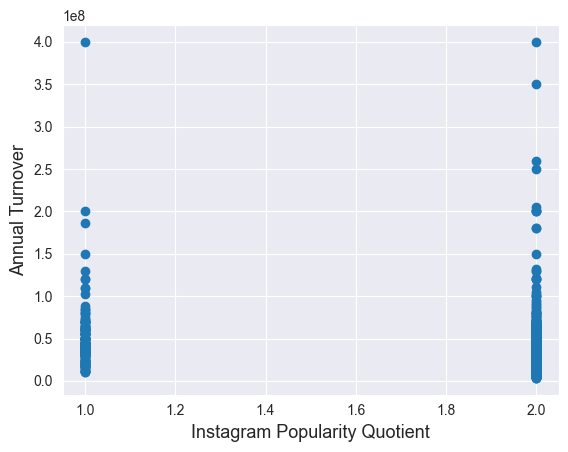

In [68]:

fig, ax = plt.subplots()
ax.scatter(x = train['Resturant Tier'], y = train['Annual Turnover'])
plt.ylabel('Annual Turnover', fontsize=13)
plt.xlabel('Instagram Popularity Quotient', fontsize=13)
plt.show()


We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers.
Therefore, we can safely delete them.

In [ ]:
# #Deleting outliers
# train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# #Check the graphic again
# fig, ax = plt.subplots()
# ax.scatter(train['GrLivArea'], train['SalePrice'])
# plt.ylabel('SalePrice', fontsize=13)
# plt.xlabel('GrLivArea', fontsize=13)
# plt.show()

### Note : 
 Outliers removal is note always safe.  We decided to delete these two as they are very huge and  really  bad ( extremely large areas for very low  prices). 

There are probably others outliers in the training data.   However, removing all them  may affect badly our models if ever there were also  outliers  in the test data. That's why , instead of removing them all, we will just manage to make some of our  models robust on them. You can refer to  the modelling part of this notebook for that. 

## Target Variable

**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.


 mu = 30725708.56 and sigma = 21648147.45



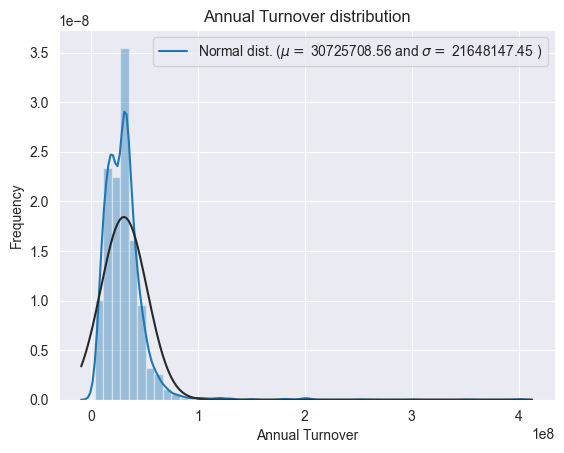

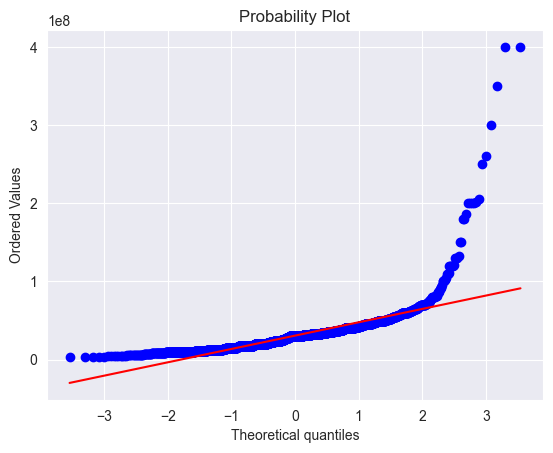

In [24]:
sns.distplot(train['Annual Turnover'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Annual Turnover'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Annual Turnover distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['Annual Turnover'], plot=plt)
plt.show()

The target variable is right skewed.  As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

#### **Log-transformation of the target variable**


 mu = 17.09 and sigma = 0.55



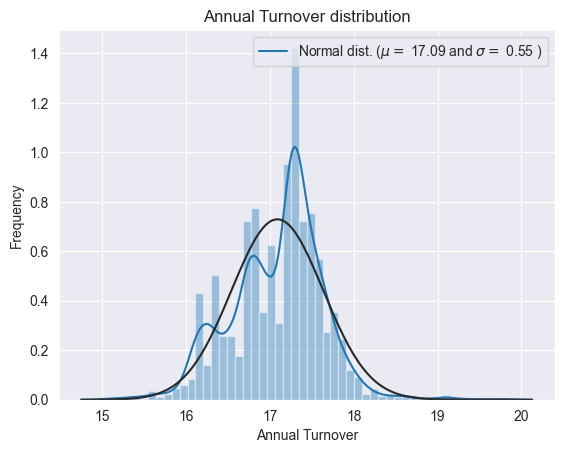

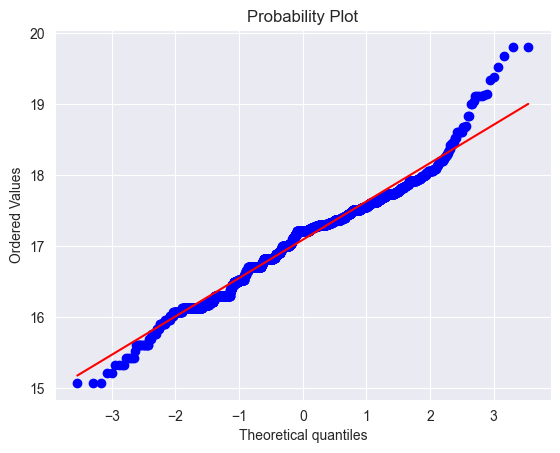

In [25]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["Annual Turnover"] = np.log1p(train["Annual Turnover"])

#Check the new distribution 
sns.distplot(train['Annual Turnover'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Annual Turnover'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Annual Turnover distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['Annual Turnover'], plot=plt)
plt.show()


The skew seems now corrected and the data appears more normally distributed. 

## Features engineering

let's first  concatenate the train and test data in the same dataframe

In [42]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train['Annual Turnover'].values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['Annual Turnover'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (3993, 32)


### Fix City

In [82]:
all_data['City'] = all_data['City'].replace('-1', 'OTHER')
all_data['City'] = all_data['City'].str.upper().str.strip()

In [84]:
replacement_pattern = r"^(BANGALORE|BANGLORE|BENGALURU)$"  # Consider using raw string for regex

# Replace matching values with 'BANGALORE' (case-sensitive)
all_data['City'] = all_data['City'].str.replace(replacement_pattern, 'BANGALORE')


replacement_pattern = r"^(BHUBANESHWAR|BHUBANESWAR)$"  # Consider using raw string for regex
all_data['City'] = all_data['City'].str.replace(replacement_pattern, 'BHUBANESHWAR')


replacement_pattern = r"^(TRIVANDRUM|THIRUVANANTHAPURAM|THIRUVANANTHAPURAM)$"  # Consider using raw string for regex
all_data['City'] = all_data['City'].str.replace(replacement_pattern, 'TRIVANDRUM')

all_data['City'].value_counts().sort_values(ascending=False)

BANGALORE     684
OTHER         461
NOIDA         389
HYDERABAD     368
PUNE          327
             ... 
DAMMAM          1
BARIPADA        1
BANAGLORE       1
ROURKELA        1
SHAHIBABAD      1
Name: City, Length: 223, dtype: int64

### Missing Data

In [43]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
Live Sports Rating,94.140
Value Deals Rating,77.436
Comedy Gigs Rating,71.450
Live Music Rating,21.713
Overall Restaurant Rating,6.161
Facebook Popularity Quotient,2.479
Instagram Popularity Quotient,1.402
Resturant Tier,1.227
Ambience,0.626


Text(0.5, 1.0, 'Percent missing data by feature')

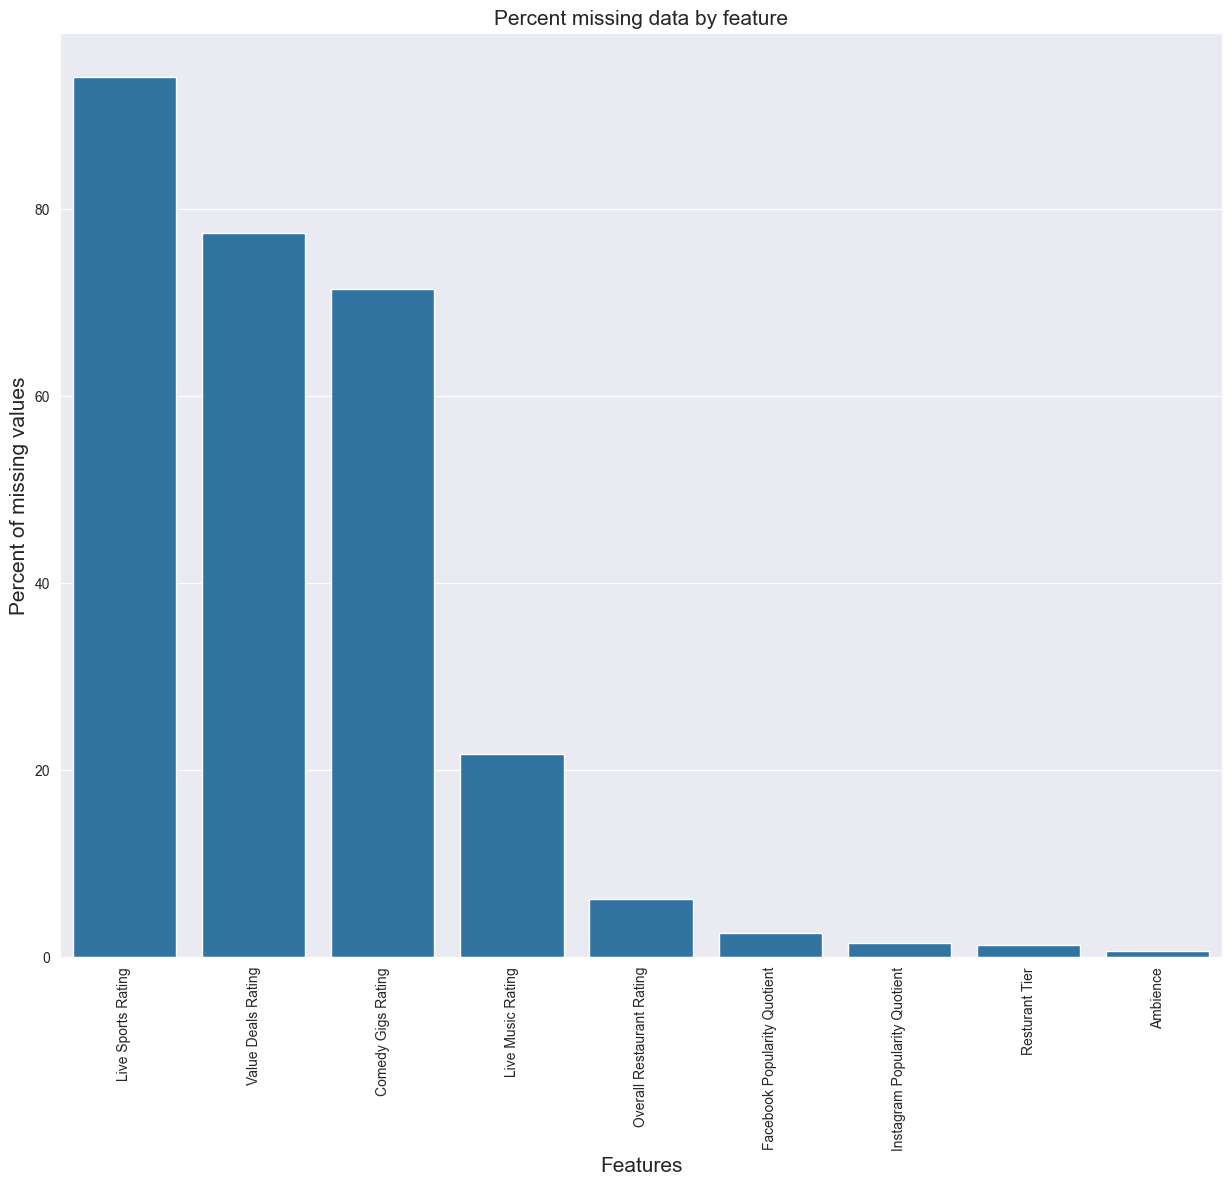

In [44]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

**Data Correlation**


<Axes: >

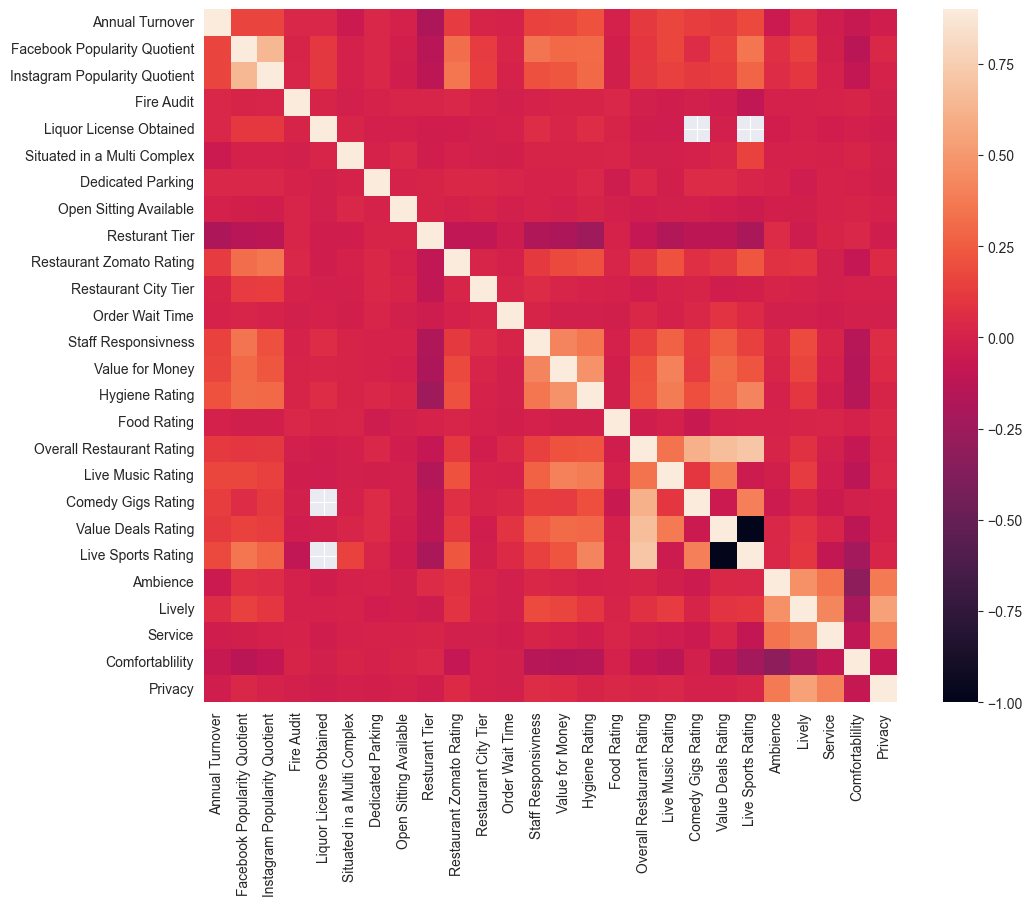

In [69]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True,color='blue')

#### Imputing missing values 

We impute them  by proceeding sequentially  through features with missing values 

Live Sports Rating	94.140
Value Deals Rating	77.436
Comedy Gigs Rating	71.450
Live Music Rating	21.713
Overall Restaurant Rating	6.161
Facebook Popularity Quotient	2.479
Instagram Popularity Quotient	1.402
Resturant Tier	1.227
Ambience	0.626

- **PoolQC** : data description says NA means "No  Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. 

In [50]:
all_data["Live Sports Rating"] = all_data["Live Sports Rating"].transform(lambda x: x.fillna(x.median()))
all_data["Live Sports Rating"].value_counts(dropna=False)

4.000    3849
3.000      88
5.000      29
2.000      22
6.000       5
Name: Live Sports Rating, dtype: int64

- **MiscFeature** : data description says NA means "no misc feature"


In [53]:
all_data["Value Deals Rating"] = all_data["Value Deals Rating"].transform(lambda x: x.fillna(x.median()))
all_data['Value Deals Rating'].value_counts(dropna=False)


4.000    3411
3.000     317
5.000     145
2.000      94
6.000      20
1.000       4
7.000       2
Name: Value Deals Rating, dtype: int64

In [55]:
all_data["Comedy Gigs Rating"] = all_data["Comedy Gigs Rating"].transform(lambda x: x.fillna(x.median()))
all_data['Comedy Gigs Rating'].value_counts(dropna=False)


3.000    3371
2.000     317
4.000     221
5.000      47
1.000      35
6.000       2
Name: Comedy Gigs Rating, dtype: int64

- **Alley** : data description says NA means "no alley access"

In [57]:
all_data["Live Music Rating"] = all_data["Live Music Rating"].transform(lambda x: x.fillna(x.median()))
all_data['Live Music Rating'].value_counts(dropna=False)


4.000    2144
3.000     780
5.000     723
6.000     183
2.000     112
1.000      32
7.000      17
8.000       2
Name: Live Music Rating, dtype: int64

In [59]:
all_data["Overall Restaurant Rating"] = all_data["Overall Restaurant Rating"].transform(lambda x: x.fillna(x.median()))
all_data['Overall Restaurant Rating'].value_counts(dropna=False)


9.000     1421
10.000     975
7.000      657
8.000      602
6.000      338
Name: Overall Restaurant Rating, dtype: int64

In [61]:
all_data["Facebook Popularity Quotient"] = all_data["Facebook Popularity Quotient"].transform(lambda x: x.fillna(x.mean()))
all_data['Facebook Popularity Quotient'].value_counts(dropna=False)


77.888    99
78.000    70
82.000    68
73.000    65
76.000    65
          ..
92.100     1
63.660     1
90.010     1
82.560     1
78.280     1
Name: Facebook Popularity Quotient, Length: 841, dtype: int64

In [62]:
all_data["Instagram Popularity Quotient"] = all_data["Instagram Popularity Quotient"].transform(lambda x: x.fillna(x.mean()))
all_data['Instagram Popularity Quotient'].value_counts(dropna=False)

70.000    72
72.000    67
74.000    61
62.000    57
74.449    56
          ..
55.550     1
65.900     1
76.770     1
68.150     1
53.550     1
Name: Instagram Popularity Quotient, Length: 796, dtype: int64

- **Fence** : data description says NA means "no fence"

In [65]:
all_data["Ambience"] = all_data["Ambience"].transform(lambda x: x.fillna(x.median()))
all_data['Ambience'].value_counts(dropna=False)


6.000     783
8.000     752
7.000     710
5.000     428
9.000     403
4.000     401
10.000    184
3.000     167
2.000     103
1.000      34
0.000      28
Name: Ambience, dtype: int64

In [72]:
all_data["Resturant Tier"] = all_data["Resturant Tier"].transform(lambda x: x.fillna(x.median()))
all_data['Resturant Tier'].value_counts(dropna=False)


2.000    3657
1.000     287
1.927      49
Name: Resturant Tier, dtype: int64

- **FireplaceQu** : data description says NA means "no fireplace"

Is there any remaining missing value ? 

In [73]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


It remains no missing value.


### More features engeneering

**Transforming some numerical variables that are really categorical**

In [ ]:
# #MSSubClass=The building class
# all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


# #Changing OverallCond into a categorical variable
# all_data['OverallCond'] = all_data['OverallCond'].astype(str)


# #Year and month sold are transformed into categorical features.
# all_data['YrSold'] = all_data['YrSold'].astype(str)
# all_data['MoSold'] = all_data['MoSold'].astype(str)



#### Label Encoding some categorical variables that may contain information in their ordering set** 

In [74]:
all_data.dtypes

Cuisine                           object
City                              object
Restaurant Location               object
Opening Day of Restaurant         object
Facebook Popularity Quotient     float64
Endorsed By                       object
Instagram Popularity Quotient    float64
Fire Audit                         int64
Liquor License Obtained            int64
Situated in a Multi Complex        int64
Dedicated Parking                  int64
Open Sitting Available             int64
Resturant Tier                   float64
Restaurant Type                   object
Restaurant Theme                  object
Restaurant Zomato Rating           int64
Restaurant City Tier               int64
Order Wait Time                    int64
Staff Responsivness                int64
Value for Money                    int64
Hygiene Rating                     int64
Food Rating                        int64
Overall Restaurant Rating        float64
Live Music Rating                float64
Comedy Gigs Rati

In [86]:
from sklearn.preprocessing import LabelEncoder
cols = ('Fire Audit', 'Liquor License Obtained', 'Situated in a Multi Complex', 'Dedicated Parking', 'Open Sitting Available','Restaurant Location')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))




Shape all_data: (3993, 34)


**Adding one more important feature**

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [ ]:
# Adding total sqfootage feature 
# all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


#### Skewed features**

In [80]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



,Skew
Restaurant City Tier,0.871
Food Rating,-0.278
Instagram Popularity Quotient,-0.397
Staff Responsivness,-0.483
Overall Restaurant Rating,-0.771
Value for Money,-0.818
Order Wait Time,-0.843
Facebook Popularity Quotient,-0.965
Hygiene Rating,-1.031
Comfortablility,-1.360


**Box Cox Transformation of (highly) skewed features**

We use the scipy  function boxcox1p which computes the Box-Cox transformation of **\\(1 + x\\)**. 

Note that setting \\( \lambda = 0 \\) is equivalent to log1p used above for the target variable.  

See [this page][1] for more details on Box Cox Transformation as well as [the scipy function's page][2]
[1]: http://onlinestatbook.com/2/transformations/box-cox.html
[2]: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [78]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 25 skewed numerical features to Box Cox transform


**Getting dummy categorical features**

#### Endorsed By OHE

In [85]:

# all_data = pd.get_dummies(all_data)
# print(all_data.shape)

all_data = pd.concat([all_data.drop('Endorsed By', 1), all_data['Endorsed By'].str.get_dummies()], 1)


#### Restaurant Type OHE

In [87]:
all_data = pd.concat([all_data.drop('Restaurant Type', 1), all_data['Restaurant Type'].str.get_dummies()], 1)


#### Date Field

In [90]:
all_data['Opening Day of Restaurant'].max()

all_data['Opening Day of Restaurant'] =  pd.to_datetime(all_data['Opening Day of Restaurant'], format='%d-%m-%Y')

launch_date = datetime.datetime(2015, 3, 23)
# scale days open
all_data['Days Open'] = (launch_date - all_data['Opening Day of Restaurant']).dt.days / 1000
all_data['Opening Year'] =  all_data['Opening Day of Restaurant'].dt.year
all_data['Opening Month'] =  all_data['Opening Day of Restaurant'].dt.month

all_data.drop('Opening Day of Restaurant', axis=1, inplace=True)
#df_test.drop('Opening Day of Restaurant', axis=1, inplace=True)

0       2009
1       2008
2       2011
3       2008
4       2010
        ... 
3988    2009
3989    2007
3990    2010
3991    2012
3992    2010
Name: Opening Year, Length: 3993, dtype: int64

Getting the new train and test sets. 

In [ ]:
train = all_data[:ntrain]
test = all_data[ntrain:]


#Modelling

**Import librairies**

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb



**Define a cross validation strategy**

We use the **cross_val_score** function of Sklearn. However this function has not a shuffle attribut, we add then one line of code,  in order to shuffle the dataset  prior to cross-validation

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

##Base models

-  **LASSO  Regression**  : 

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline 

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- **Elastic Net Regression** :

again made robust to outliers

In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **Kernel Ridge Regression** :

In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers
    

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

- **XGBoost** :

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)



- **LightGBM** :

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

###Base models scores

Let's see how these base models perform on the data by evaluating the  cross-validation rmsle error

In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

##Stacking  models

###Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models.  We build a new **class**  to extend scikit-learn with our model and also to laverage encapsulation and code reuse ([inheritance][1]) 


  [1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

**Averaged base models class**

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

**Averaged base models score**

We just average four models here **ENet, GBoost,  KRR and lasso**.  Of course we could easily add more models in the mix. 

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Wow ! It seems even the simplest stacking approach really improve the score . This encourages 
us to go further and explore a less simple stacking approch. 

###Less simple Stacking : Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model. 

The procedure, for the training part, may be described as follows:


1. Split the total training set into two disjoint sets (here **train** and .**holdout** )

2. Train several base models on the first part (**train**)

3. Test these base models on the second part (**holdout**)

4. Use the predictions from 3)  (called  out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs  to train a higher level learner called **meta-model**.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration,  we train every base model on 4 folds and predict on the remaining fold (holdout fold). 

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as 
new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of  all base models on the test data  and used them as **meta-features**  on which, the final prediction is done with the meta-model.


![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Image taken from [Faron](https://www.kaggle.com/getting-started/18153#post103381))

![kaz](http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2017/06/image5.gif)

Gif taken from [KazAnova's interview](http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/)

On this gif, the base models are algorithms 0, 1, 2 and the meta-model is algorithm 3. The entire training dataset is 
A+B (target variable y known) that we can split into train part (A) and holdout part (B). And the test dataset is C. 

B1 (which is the prediction from the holdout part)  is the new feature used to train the meta-model 3 and C1 (which
is the prediction  from the test dataset) is the meta-feature on which the final prediction is done. 

**Stacking averaged Models Class**

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

**Stacking Averaged models Score**

To make the two approaches comparable (by using the same number of models) , we just average **Enet KRR and Gboost**, then we add **lasso as meta-model**.

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

We get again a better score by adding a meta learner

## Ensembling StackedRegressor, XGBoost and LightGBM

We add **XGBoost and LightGBM** to the** StackedRegressor** defined previously. 

We first define a rmsle evaluation function 

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

###Final Training and Prediction

**StackedRegressor:**

In [ ]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

**XGBoost:**

In [ ]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

**LightGBM:**

In [ ]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

In [ ]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

**Ensemble prediction:**

In [ ]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

**Submission**

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

**If you found this notebook helpful or you just liked it , some upvotes would be very much appreciated -  That will keep me motivated to update it on a regular basis** :-)